## Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

## Hyperparameters

In [14]:
INPUT_DIM = 6
HIDDEN_DIM1 = 64
HIDDEN_DIM2 = 32
TIMESTEPS = 50
TRAIN_RATIO = 0.8
EPOCHS = 100
BATCH_SIZE = 1000
LEARNING_RATE = 0.0001
SEED = 13
DATA_PATH = "./Dataset/"
stateful = False

In [15]:
np.random.seed(SEED)

## Load Dataset

In [16]:
# file_paths = sorted(glob.glob(os.path.join(DATA_PATH, "*.csv")))
file_paths = "./Dataset/har70+_505.csv"

In [17]:
df = pd.read_csv(file_paths)
har_data = df

In [18]:
# all_data = []
# for file in file_paths:
#     df = pd.read_csv(file)
#     df['source_file'] = os.path.basename(file)
#     all_data.append(df)

# har_data = pd.concat(all_data, ignore_index=True)

## Data Visualization

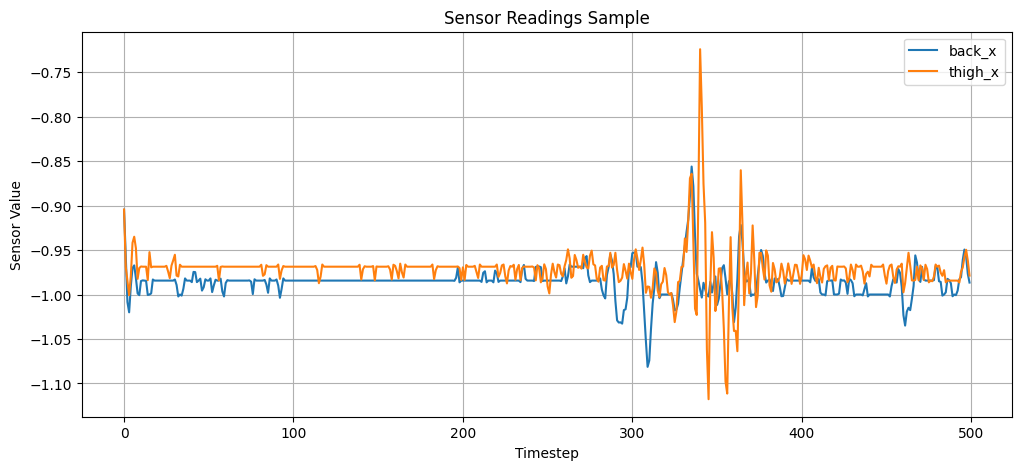

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(har_data['back_x'][:500], label="back_x")
plt.plot(har_data['thigh_x'][:500], label="thigh_x")
plt.title("Sensor Readings Sample")
plt.xlabel("Timestep")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

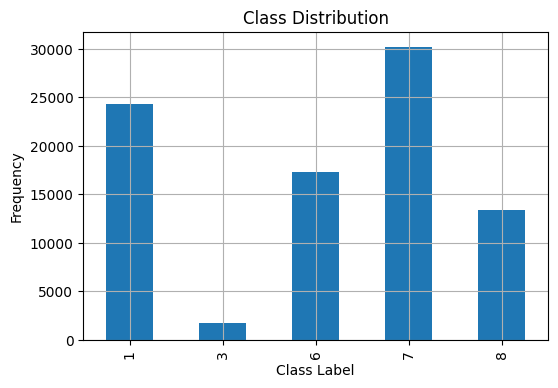

In [20]:
plt.figure(figsize=(6, 4))
har_data['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Data Preprocessing

In [21]:
features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
X_raw = har_data[features].values
y_raw = har_data['label'].values

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [23]:
X_seq, y_seq = create_lstm_sequences(X_scaled, y_raw, TIMESTEPS)

In [24]:
unique_labels = np.unique(y_seq)
print("Original labels before mapping:", unique_labels)

label_map = {old: new for new, old in enumerate(unique_labels)}
print("\nLabel mapping:")
for original, new in label_map.items():
    print(f"  Original Label {original} → Mapped Label {new}")

print("\nClass Distribution before Mapping:")
unique, counts = np.unique(y_seq, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples")

print("\ny_seq range:", y_seq.min(), "to", y_seq.max())

Original labels before mapping: [1 3 6 7 8]

Label mapping:
  Original Label 1 → Mapped Label 0
  Original Label 3 → Mapped Label 1
  Original Label 6 → Mapped Label 2
  Original Label 7 → Mapped Label 3
  Original Label 8 → Mapped Label 4

Class Distribution before Mapping:
  Class 1: 24313 samples
  Class 3: 1768 samples
  Class 6: 17269 samples
  Class 7: 30226 samples
  Class 8: 13380 samples

y_seq range: 1 to 8


In [25]:
# unique_labels = np.unique(y_seq)
# print(unique_labels)
# label_map = {old: new for new, old in enumerate(unique_labels)}

In [26]:
y_seq_mapped = np.array([label_map[y] for y in y_seq])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq_mapped, test_size=1-TRAIN_RATIO, random_state=SEED, stratify=y_seq_mapped)

In [28]:
np.unique(y_train), y_train.min(), y_train.max()

(array([0, 1, 2, 3, 4]), 0, 4)

In [29]:
OUTPUT_DIM = len(unique_labels)

In [30]:
print("Class Distribution After Mapping:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

print("\ny_train range:", y_train.min(), "to", y_train.max())
print("OUTPUT_DIM:", OUTPUT_DIM)

Class Distribution After Mapping:
Class 0: 19450 samples
Class 1: 1414 samples
Class 2: 13815 samples
Class 3: 24181 samples
Class 4: 10704 samples

y_train range: 0 to 4
OUTPUT_DIM: 5


## Data Rebalancing

In [31]:
X_reshaped = X_seq.reshape(len(X_seq), -1)
rus = RandomUnderSampler(random_state=SEED)
X_balanced, y_balanced = rus.fit_resample(X_reshaped, y_seq_mapped)
X_balanced = X_balanced.reshape(-1, TIMESTEPS, INPUT_DIM)
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=SEED)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=1 - TRAIN_RATIO, random_state=SEED, stratify=y_balanced
)

In [33]:
_, counts = np.unique(y_train, return_counts=True)
total = np.sum(counts)
class_weights = total / (counts * len(counts))

## Create Sequence

In [34]:
def create_lstm_sequences(X, y, timesteps=50):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps-1])
    return np.array(X_seq), np.array(y_seq)

## Batch Norm

In [35]:
class BatchNorm:
    def __init__(self, dim, eps=1e-5):
        self.gamma = np.ones((dim, 1))
        self.beta = np.zeros((dim, 1))
        self.eps = eps

    def forward(self, x):
        self.mu = np.mean(x, keepdims=True)
        self.var = np.var(x, keepdims=True)
        self.x_norm = (x - self.mu) / np.sqrt(self.var + self.eps)
        return self.gamma * self.x_norm + self.beta

    def backward(self, dout):
        N = dout.shape[0]
        x_mu = self.x_norm
        std_inv = 1. / np.sqrt(self.var + self.eps)

        dx_norm = dout * self.gamma
        dvar = np.sum(dx_norm * (x_mu * -0.5) * std_inv**3, axis=0)
        dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2. * x_mu, axis=0)
        dx = dx_norm * std_inv + dvar * 2 * x_mu / N + dmu / N

        self.dgamma = np.sum(dout * x_mu, axis=0, keepdims=True).T
        self.dbeta = np.sum(dout, axis=0, keepdims=True).T
        return dx

    def apply_grads(self, lr):
        self.gamma -= lr * self.dgamma
        self.beta -= lr * self.dbeta

## Functions

In [36]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

In [37]:
def cross_entropy(pred, label, num_classes):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    return -np.sum(y_onehot * np.log(pred + 1e-8))

In [38]:
def cross_entropy(pred, label, num_classes, class_weights=None):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    weight = class_weights[label] if class_weights is not None else 1.0
    return -weight * np.sum(y_onehot * np.log(pred + 1e-8))

In [39]:
def d_cross_entropy(pred, label, num_classes):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    return pred - y_onehot

In [40]:
def d_cross_entropy(pred, label, num_classes, class_weights=None):
    y_onehot = np.zeros((num_classes, 1))
    y_onehot[label] = 1
    weight = class_weights[label] if class_weights is not None else 1.0
    return weight * (pred - y_onehot)

In [41]:
def clip_gradients(gradients, max_norm=1.0):
    total_norm = np.sqrt(sum(np.sum(g**2) for g in gradients))
    if total_norm > max_norm:
        scale = max_norm / (total_norm + 1e-6)
        return [g * scale for g in gradients]
    return gradients

## Model

### Base LSTM

In [42]:
class LSTMCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        def init(): return np.random.randn(hidden_dim, input_dim + hidden_dim) / np.sqrt(input_dim + hidden_dim)
        self.Wf, self.bf = init(), np.zeros((hidden_dim, 1))
        self.Wi, self.bi = init(), np.zeros((hidden_dim, 1))
        self.Wc, self.bc = init(), np.zeros((hidden_dim, 1))
        self.Wo, self.bo = init(), np.zeros((hidden_dim, 1))

    def sigmoid(self, x): return 1 / (1 + np.exp(-x))

    def forward(self, x_seq, h=None, c=None, keep_state=False):
        if h is None: h = np.zeros((self.hidden_dim, 1))
        if c is None: c = np.zeros((self.hidden_dim, 1))

        cache = []
        for xt in x_seq:
            xt = xt.reshape(-1, 1)
            concat = np.vstack((h, xt))
            ft = self.sigmoid(self.Wf @ concat + self.bf)
            it = self.sigmoid(self.Wi @ concat + self.bi)
            ct = np.tanh(self.Wc @ concat + self.bc)
            c = ft * c + it * ct
            ot = self.sigmoid(self.Wo @ concat + self.bo)
            h = ot * np.tanh(c)
            cache.append({'xt': xt, 'concat': concat, 'ft': ft, 'it': it, 'ct': ct, 'c': c.copy(), 'ot': ot, 'h': h.copy()})

        return (h, c, cache) if keep_state else (h, c, None)

    def zero_grads(self):
        self.dWf = np.zeros_like(self.Wf)
        self.dbf = np.zeros_like(self.bf)
        self.dWi = np.zeros_like(self.Wi)
        self.dbi = np.zeros_like(self.bi)
        self.dWc = np.zeros_like(self.Wc)
        self.dbc = np.zeros_like(self.bc)
        self.dWo = np.zeros_like(self.Wo)
        self.dbo = np.zeros_like(self.bo)

    def backward(self, dh_next, dc_next, cache):
        self.zero_grads()
        dh_lstm_prev = []
        for t in reversed(range(len(cache))):
            c_t = cache[t]
            xt, concat = c_t['xt'], c_t['concat']
            ft, it, ct, ot, c = c_t['ft'], c_t['it'], c_t['ct'], c_t['ot'], c_t['c']
            c_prev = cache[t-1]['c'] if t > 0 else np.zeros_like(c)

            tanh_c = np.tanh(c)
            do = dh_next * tanh_c * ot * (1 - ot)
            dc = dh_next * ot * (1 - tanh_c**2) + dc_next
            df = dc * c_prev * ft * (1 - ft)
            di = dc * ct * it * (1 - it)
            dct = dc * it * (1 - ct**2)

            self.dWf += df @ concat.T
            self.dbf += df
            self.dWi += di @ concat.T
            self.dbi += di
            self.dWc += dct @ concat.T
            self.dbc += dct
            self.dWo += do @ concat.T
            self.dbo += do

            d_concat = self.Wf.T @ df + self.Wi.T @ di + self.Wc.T @ dct + self.Wo.T @ do
            dh_next = d_concat[:self.hidden_dim, :]
            dc_next = dc * ft
            dh_lstm_prev.append(d_concat[self.hidden_dim:, :])

        return dh_lstm_prev[::-1]  # Reverse to match time step order

    def apply_grads(self, lr):
        for param, grad in zip(
            [self.Wf, self.bf, self.Wi, self.bi, self.Wc, self.bc, self.Wo, self.bo],
            [self.dWf, self.dbf, self.dWi, self.dbi, self.dWc, self.dbc, self.dWo, self.dbo]
        ):
            param -= lr * grad


### Stacked LSTM

In [43]:
class StackedLSTMClassifier:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, stateful=False):
        self.stateful = stateful
        self.lstm1 = LSTMCell(input_dim, hidden1)
        self.lstm2 = LSTMCell(hidden1, hidden2)
        self.W_out = np.random.randn(output_dim, hidden2) / np.sqrt(hidden2)
        self.b_out = np.zeros((output_dim, 1))
        self.batchnorm = BatchNorm(output_dim)
        self.h1, self.c1 = None, None
        self.h2, self.c2 = None, None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0, keepdims=True)

    def forward(self, x_seq):
        # First LSTM: process entire sequence, keep only final hidden state
        h1 = self.h1 if (self.stateful and self.h1 is not None) else np.zeros((self.lstm1.hidden_dim, 1))
        c1 = self.c1 if (self.stateful and self.c1 is not None) else np.zeros((self.lstm1.hidden_dim, 1))
        h1, c1, cache1 = self.lstm1.forward(x_seq, h1, c1, keep_state=True)
        if self.stateful:
            self.h1, self.c1 = h1, c1
        self.cache1 = cache1

        # Second LSTM: process only the final hidden state from LSTM1
        h2 = self.h2 if (self.stateful and self.h2 is not None) else np.zeros((self.lstm2.hidden_dim, 1))
        c2 = self.c2 if (self.stateful and self.c2 is not None) else np.zeros((self.lstm2.hidden_dim, 1))
        h2, c2, cache2 = self.lstm2.forward([h1], h2, c2, keep_state=True)
        if self.stateful:
            self.h2, self.c2 = h2, c2
        self.cache2 = cache2

        # Output layer: use final hidden state from LSTM2
        self.h2 = h2
        logits = self.W_out @ h2 + self.b_out
        logits = self.batchnorm.forward(logits)
        self.probs = self.softmax(logits)
        return self.probs.flatten()

    def backward(self, d_output):
        d_output = d_output.reshape(-1, 1)
        self.dW_out = d_output @ self.h2.T
        self.db_out = d_output
        d_output = self.batchnorm.backward(d_output)

        # Backward through LSTM2
        dh2_next = self.W_out.T @ d_output
        dc2_next = np.zeros_like(dh2_next)
        dh_lstm1 = self.lstm2.backward(dh2_next, dc2_next, self.cache2)

        # Backward through LSTM1: only the last time step's gradient is needed
        self.lstm1.zero_grads()
        dh1_next = dh_lstm1[0]  # Gradient from LSTM2's input (h1 from LSTM1)
        dc1_next = np.zeros_like(dh1_next)
        self.lstm1.backward(dh1_next, dc1_next, self.cache1)

    def apply_grads(self, lr):
        self.W_out -= lr * self.dW_out
        self.b_out -= lr * self.db_out
        self.lstm1.apply_grads(lr)
        self.lstm2.apply_grads(lr)
        self.batchnorm.apply_grads(lr)

    def reset_states(self):
        self.h1, self.c1 = None, None
        self.h2, self.c2 = None, None


In [44]:
# del StackedLSTMClassifier
# del model, train_losses, train_accuracies, test_losses, test_accuracies

## Main

### Train

In [45]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [46]:
model = StackedLSTMClassifier(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM)

In [47]:
for epoch in range(EPOCHS):
    loss = 0
    correct = 0
    total = 0

    for i in range(BATCH_SIZE):
        probs = model.forward(X_train[i])
        loss += cross_entropy(probs, y_train[i], OUTPUT_DIM, class_weights)
        d_out = d_cross_entropy(probs.reshape(-1, 1), y_train[i], OUTPUT_DIM, class_weights)
        model.backward(d_out)

        model.apply_grads(LEARNING_RATE)

        pred_label = np.argmax(probs)
        true_label = y_train[i]
        if pred_label == true_label:
            correct += 1
        total += 1

    avg_loss = loss / total
    accuracy = correct / total

    print(f"Epoch {epoch+1}\nTrain Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    test_loss = 0
    test_correct = 0
    test_total = len(X_test)

    for i in range(test_total):
        probs_test = model.forward(X_test[i])
        test_loss += cross_entropy(probs_test, y_test[i], OUTPUT_DIM, class_weights)
        pred_label_test = np.argmax(probs_test)
        if pred_label_test == y_test[i]:
            test_correct += 1

    test_avg_loss = test_loss / test_total
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n")
    test_losses.append(test_avg_loss)
    test_accuracies.append(test_accuracy)

Epoch 1
Train Loss: 10.0218, Train Accuracy: 0.2060
Test Loss: 9.7972, Test Accuracy: 0.2002

Epoch 2
Train Loss: 9.5872, Train Accuracy: 0.2050
Test Loss: 9.4068, Test Accuracy: 0.2002

Epoch 3
Train Loss: 9.2356, Train Accuracy: 0.2050
Test Loss: 9.0908, Test Accuracy: 0.2002

Epoch 4
Train Loss: 8.9536, Train Accuracy: 0.2050
Test Loss: 8.8398, Test Accuracy: 0.2002

Epoch 5
Train Loss: 8.7320, Train Accuracy: 0.2050
Test Loss: 8.6446, Test Accuracy: 0.2002

Epoch 6
Train Loss: 8.5613, Train Accuracy: 0.2050
Test Loss: 8.4956, Test Accuracy: 0.2002

Epoch 7
Train Loss: 8.4324, Train Accuracy: 0.2050
Test Loss: 8.3842, Test Accuracy: 0.2002

Epoch 8
Train Loss: 8.3370, Train Accuracy: 0.2050
Test Loss: 8.3024, Test Accuracy: 0.2002

Epoch 9
Train Loss: 8.2676, Train Accuracy: 0.2050
Test Loss: 8.2434, Test Accuracy: 0.2002

Epoch 10
Train Loss: 8.2181, Train Accuracy: 0.2050
Test Loss: 8.2018, Test Accuracy: 0.2002

Epoch 11
Train Loss: 8.1836, Train Accuracy: 0.2050
Test Loss: 8.173

## Result

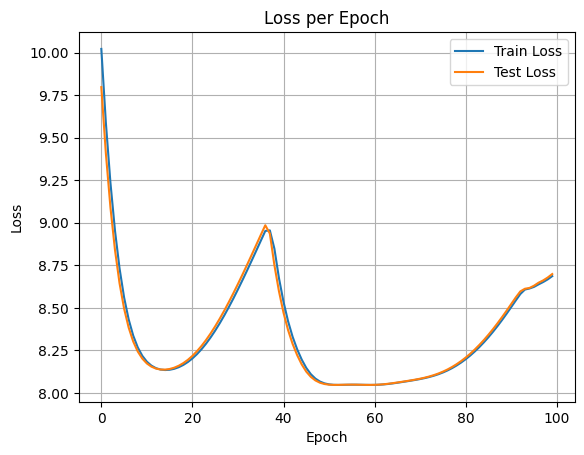

In [48]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss per Epoch - Stacked LSTM - Small DB")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

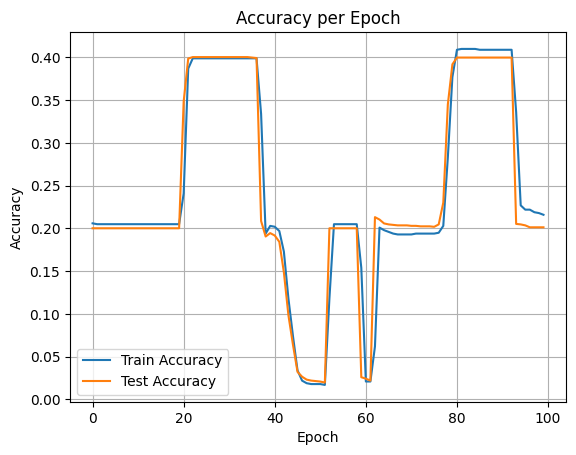

In [49]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy per Epoch - Stacked LSTM - Small DB")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()